In [19]:
import os

from datetime import datetime

import pandas as pd
import newspaper

from PIL import Image, ImageFont, ImageDraw 
import textwrap

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.chunk import ne_chunk

from transformers import pipeline

import warnings
warnings.filterwarnings('ignore')

# Download necessary NLTK resources
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')



# Run date
current_date = datetime.now().date()
print("Current date:", current_date)

url_list = ['https://www.businesstoday.in'
            #,'https://www.financialexpress.com'
            #,'https://www.moneycontrol.com/stocksmarketsindia/'
           ]

print(url_list)


env = 'dev' #[prod, dev]

# Create new dirs
if not os.path.exists('{}/sourced_news/{}'.format(env, current_date)):
    os.mkdir('{}/sourced_news/{}'.format(env, current_date))
    
if not os.path.exists('{}/cleaned_news/{}'.format(env, current_date)):
    os.mkdir('{}/cleaned_news/{}'.format(env, current_date))
    
if not os.path.exists('{}/images/{}'.format(env, current_date)):
    os.mkdir('{}/images/{}'.format(env, current_date))
    
print(newspaper.hot())

[nltk_data] Downloading package stopwords to /Users/aman/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/aman/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/aman/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /Users/aman/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /Users/aman/nltk_data...
[nltk_data]   Package words is already up-to-date!


Current date: 2023-07-21
['https://www.businesstoday.in']
['Powerball', 'Ethan Slater', 'Kevin Mitnick', 'Dan Snyder', 'Jordan Addison', 'G Herbo', 'Rory McIlroy', 'Robert F. Kennedy Jr', 'Nigeria vs Canada', 'Justin Thomas', 'Christo Lamprecht', 'Premios Juventud 2023', 'Kevin Maxen', 'Matthew McConaughey', 'Diablo 4 Season 1', 'Mayans M.C', 'Rickie Fowler', 'FedNow', 'Henry Kissinger', 'Marc Tessier-Lavigne']


In [17]:
## Method definitions

# extract_articles
def extract_articles(article):
    try:
        article.download()
        article.parse()
        article.nlp()
        news.append(link + "~|~" + article.url + "~|~" + article.title + "~|~" + str(article.publish_date) + "~|~" + article.summary + "~|~" + str(article.keywords) + "~|~" + article.text)            
    except:
        print('issue in article')
        pass
    return news

# dump_articles
def dump_articles(i, news):
    data = [row.split("~|~") for row in news]
    df = pd.DataFrame(data)
    df.columns = ["source", "link", "title", "publish_date", "summary", "keywords", "desc"]
    df.to_csv('{}/sourced_news/{}/{}_news_articles.csv'.format(env, current_date, i), index=False)
    
    
# Pull news articles    
for index, link in enumerate(url_list):
    print(f"Index: {index}, Url: {link}")
    
    news = []
    if env=='prod':
        paper = newspaper.build(link, 
                                language='en', 
                                memoize_articles=True,
                                fetch_images=False)
    elif env=='dev':
        paper = newspaper.build(link, 
                                language='en', 
                                memoize_articles=False,
                                fetch_images=False)
    print('paper size: ', paper.size())
    
    for category_urls in paper.category_urls():
        print('category_urls: ' + category_urls)
        url = newspaper.build(category_urls, language='en', memoize_articles=True)
        
        if index == 0:
            for article in url.articles:
                if str(current_date) in article.url:
                    #print(article.url)
                    extract_articles(article)
                    
        elif index == 1:
            for article in url.articles[:20]:
                extract_articles(article)
            
        elif index == 2:
            for article in paper.articles:
                if article.url.count('-') > 2:
                    if "https://gujarati.moneycontrol.com" not in article.url:
                        if ".html" in article.url:
                            extract_articles(article)
                        
    if news:
        dump_articles(index, news)
    else:
        print("No news articles found")

Index: 0, Url: https://www.businesstoday.in
paper size:  501
category_urls: https://www.businesstoday.in
category_urls: https://www.businesstoday.in/industry
category_urls: https://www.businesstoday.in/visualstories
category_urls: https://bazaar.businesstoday.in
category_urls: https://www.businesstoday.in/indices
category_urls: https://www.businesstoday.in
category_urls: https://www.businesstoday.in/short-videos
category_urls: https://www.businesstoday.in/magazine
category_urls: https://www.businesstoday.in/trending
category_urls: https://www.businesstoday.in/prnewswire
category_urls: https://www.businesstoday.in/coronavirus
category_urls: https://www.businesstoday.in/topic
category_urls: https://www.businesstoday.in/lifestyle
category_urls: https://www.businesstoday.in/education
category_urls: https://www.businesstoday.in/photos
category_urls: https://www.businesstoday.in/markets
category_urls: https://www.businesstoday.in/opinion
category_urls: https://www.businesstoday.in/partners
c

### Clean the news

In [20]:
# Read today's collected news
directory_path = '{}/sourced_news/{}'.format(env, current_date)
csv_files = [file for file in os.listdir(directory_path) if file.endswith('.csv')]

dataframes = []

for file in csv_files:
    file_path = os.path.join(directory_path, file)
    df = pd.read_csv(file_path)
    dataframes.append(df)

# Concatenate all DataFrames into a single DataFrame
combined_df = pd.concat(dataframes, ignore_index=True)
print(combined_df.shape)
print(combined_df.head())

news = combined_df



# Clean the news - drop dups, filter
news = news.dropna()

news['dt'] = news['publish_date'].str.slice(0, 10)
news.drop(columns='publish_date', inplace=True)
news.rename(columns={'dt': 'publish_date'}, inplace=True)

news = news[["source", "link", "title", "publish_date", "summary", "keywords", "desc"]]
news['publish_date'] = news['publish_date'].fillna(str(current_date))
news['publish_date'] = news['publish_date'].replace('None', str(current_date))

print(news['source'].unique())
print(news.shape)
news.to_csv('{}/cleaned_news/{}/news.csv'.format(env, current_date), index=False)

(63, 7)
                         source  \
0  https://www.businesstoday.in   
1  https://www.businesstoday.in   
2  https://www.businesstoday.in   
3  https://www.businesstoday.in   
4  https://www.businesstoday.in   

                                                link  \
0  https://www.businesstoday.in/technology/news/s...   
1  https://bazaar.businesstoday.in/world/story/ho...   
2  https://bazaar.businesstoday.in/business/story...   
3  https://bazaar.businesstoday.in/world/story/up...   
4  https://bazaar.businesstoday.in/world/story/ri...   

                                               title         publish_date  \
0  North Korean hackers breached a US tech compan...  2023-07-21 00:00:00   
1      Chandrayaan-3 कहाँ तक पंहुचा, कब करेगा लैंडिग  2023-07-21 00:00:00   
2  Foxconn की तैयारी जोरो पर, Tamil Nadu और Karna...  2023-07-21 00:00:00   
3  Manipur पर दूसरे दिन भी संसद में हंगामा, लोकसभ...  2023-07-21 00:00:00   
4  चावल की कीमतों पर लगेगी लगाम, सफेद चावल के एक्...  2023-

### Select top random news articles

In [22]:
df = pd.read_csv('{}/cleaned_news/{}/news.csv'.format(env, current_date)).drop_duplicates(subset=['title'])
print(df.groupby('source').count())

#print(df['source'].unique())
#print(df['publish_date'].unique())
#print(df.groupby('publish_date').count())

df = df[df['publish_date'] == str(current_date)]

df['summary'] = df['summary'].str.strip()
df['title'] = df['title'].str.strip()
df = df[df['summary'].str.len() >= 400]
df = df[df['summary'].str.len() <= 1000]

#df = df[df['desc'].str.len() <= 3000]

sample_size_per_group = 30
def take_sample(group):
    return group.sample(n=min(sample_size_per_group, len(group)))

df = df.groupby('source', group_keys=False).apply(take_sample)


print(df.shape)
#print(df['source'].unique())
print(df.groupby('publish_date').count())
df[['publish_date', 'title', 'summary']]

                              link  title  publish_date  summary  keywords  \
source                                                                       
https://www.businesstoday.in    52     52            52       52        52   

                              desc  
source                              
https://www.businesstoday.in    52  
(30, 7)
              source  link  title  summary  keywords  desc
publish_date                                              
2023-07-21        30    30     30       30        30    30


,publish_date,title,summary
37,2023-07-21,'Bawaal' Twitter review: Varun Dhawan-Janhvi K...,Varun Dhawan-Janhvi Kapoor starrer Bawaal has ...
7,2023-07-21,Aircraft leasing units at GIFT City get a brea...,In a boost to the aircraft leasing business at...
18,2023-07-21,JSW Steel shares climb 3% after better-than-ex...,Shares of JSW Steel jumped 3 per cent in Frida...
47,2023-07-21,Pfizer plant in North Carolina damaged by tornado,Drugmaker Pfizer Inc said on Wednesday its pla...
46,2023-07-21,Is pledging shares and mutual funds better tha...,You have some investments in shares and mutual...
12,2023-07-21,"RITES, RVNL, IRCON, other railway stocks jump ...","Railways stocks such as RITES Ltd, Rail Vikas ..."
23,2023-07-21,"Foxconn Raises Its Stake, Bets Big On India, F...",Foxconn is ramping up its investments in India...
49,2023-07-21,"FTX sues Bankman-Fried, others to recoup more ...",FTX Trading on Thursday sued founder Sam Bankm...
22,2023-07-21,SAP CEO Christian Klein Sees India As A Clear ...,"German technology giant SAP, whose enterprise ..."
10,2023-07-21,"After France, UPI reaches Sri Lanka! PM Modi s...",Prime Minister Narendra Modi and Sri Lanka Pre...


## Generate images

post generation done


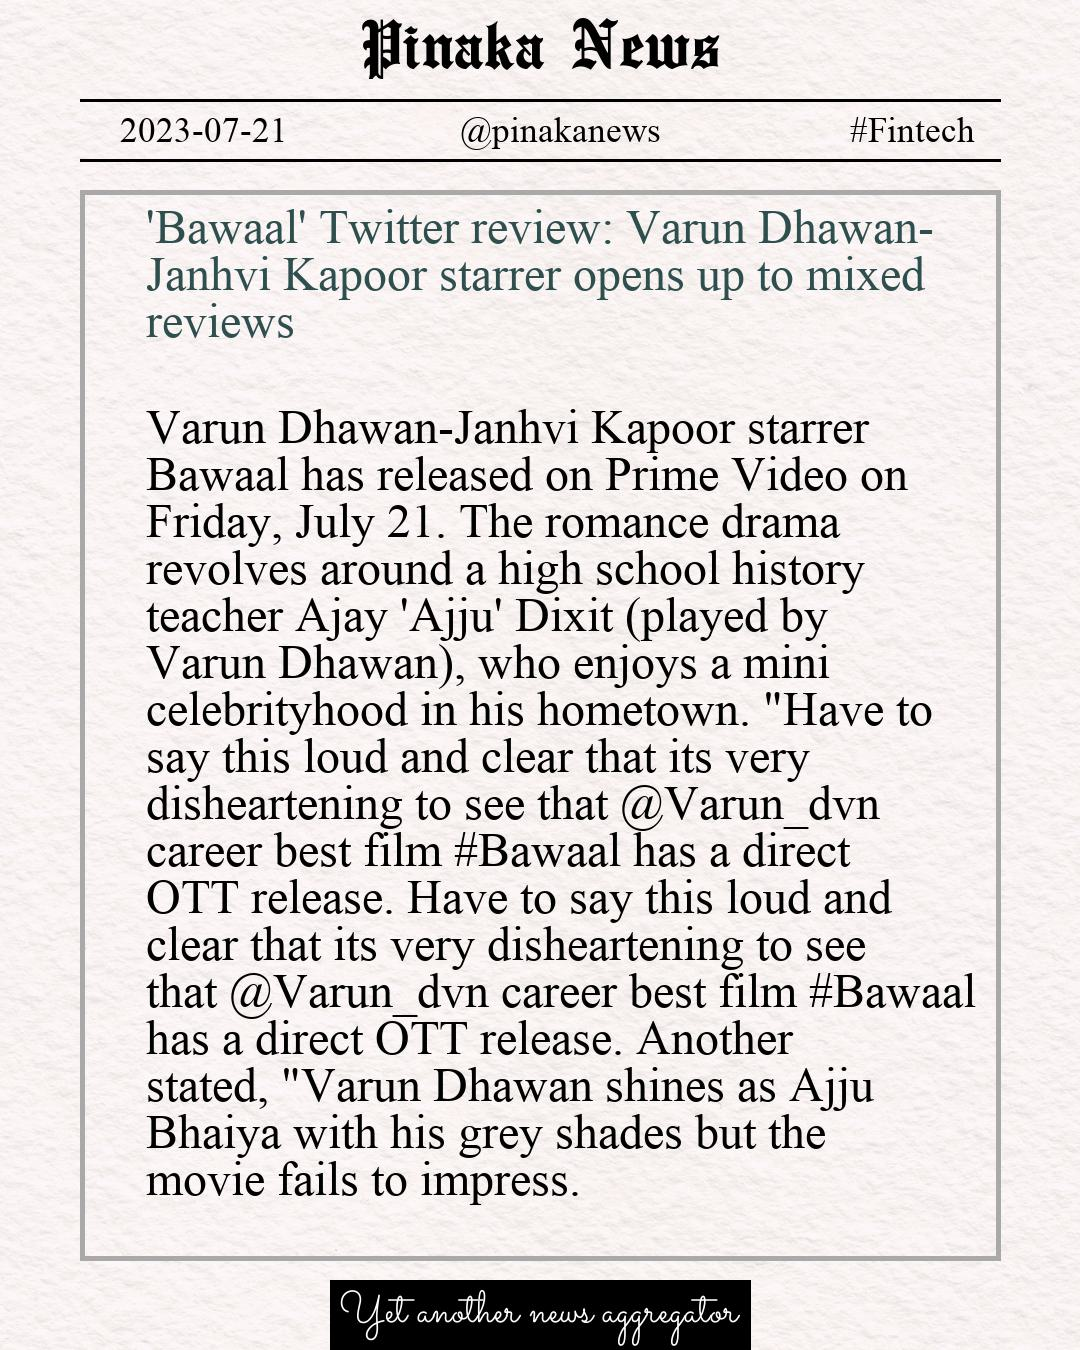

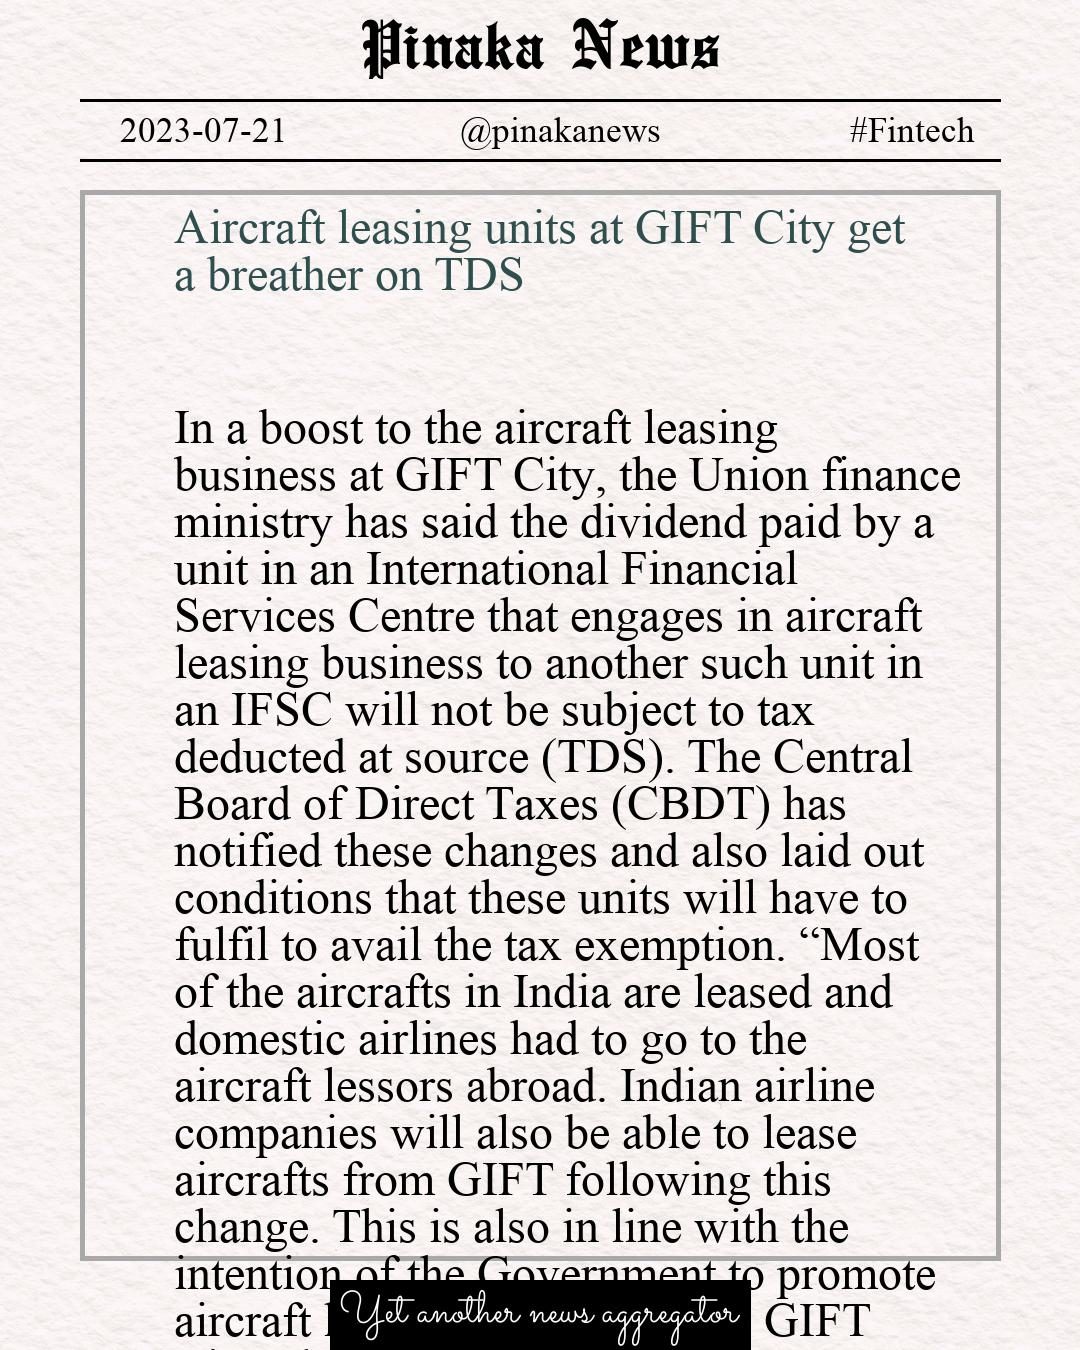

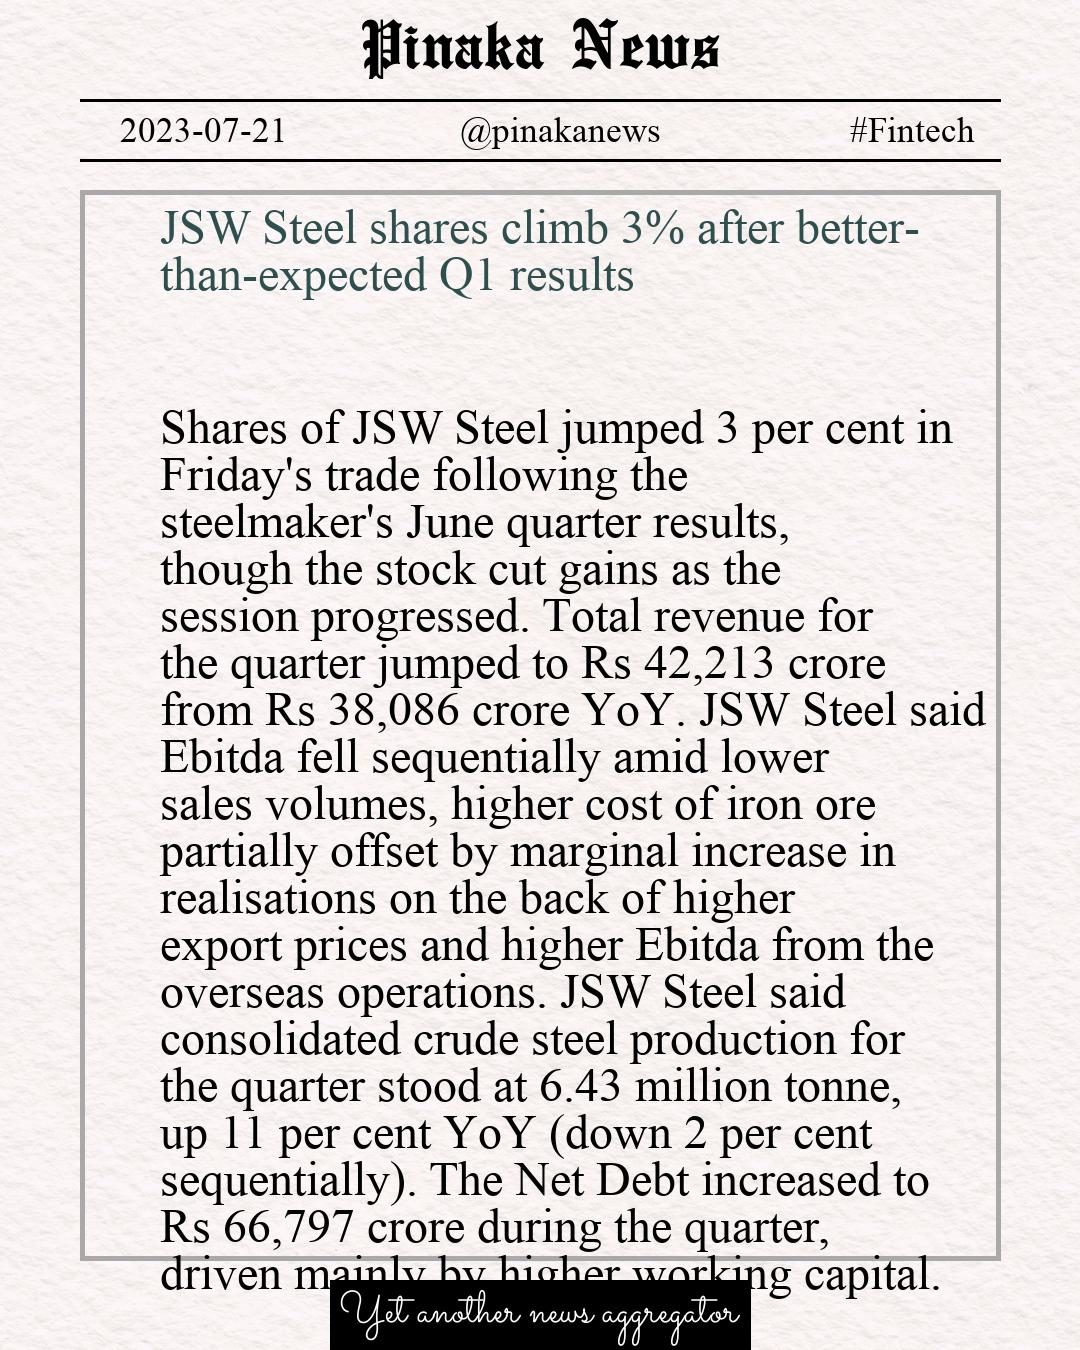

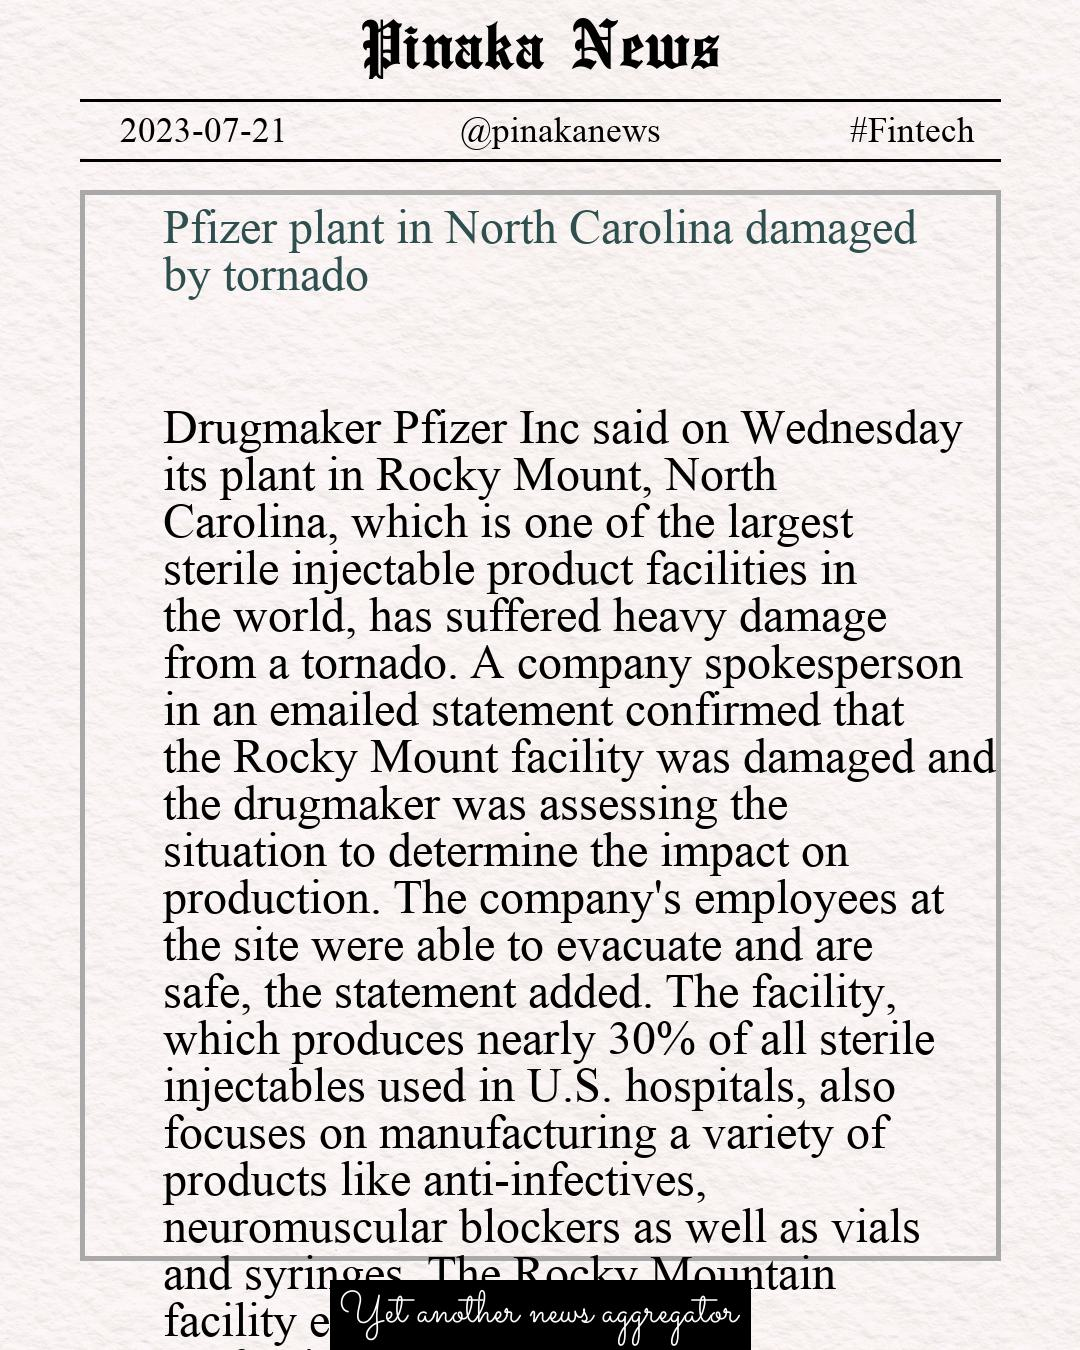

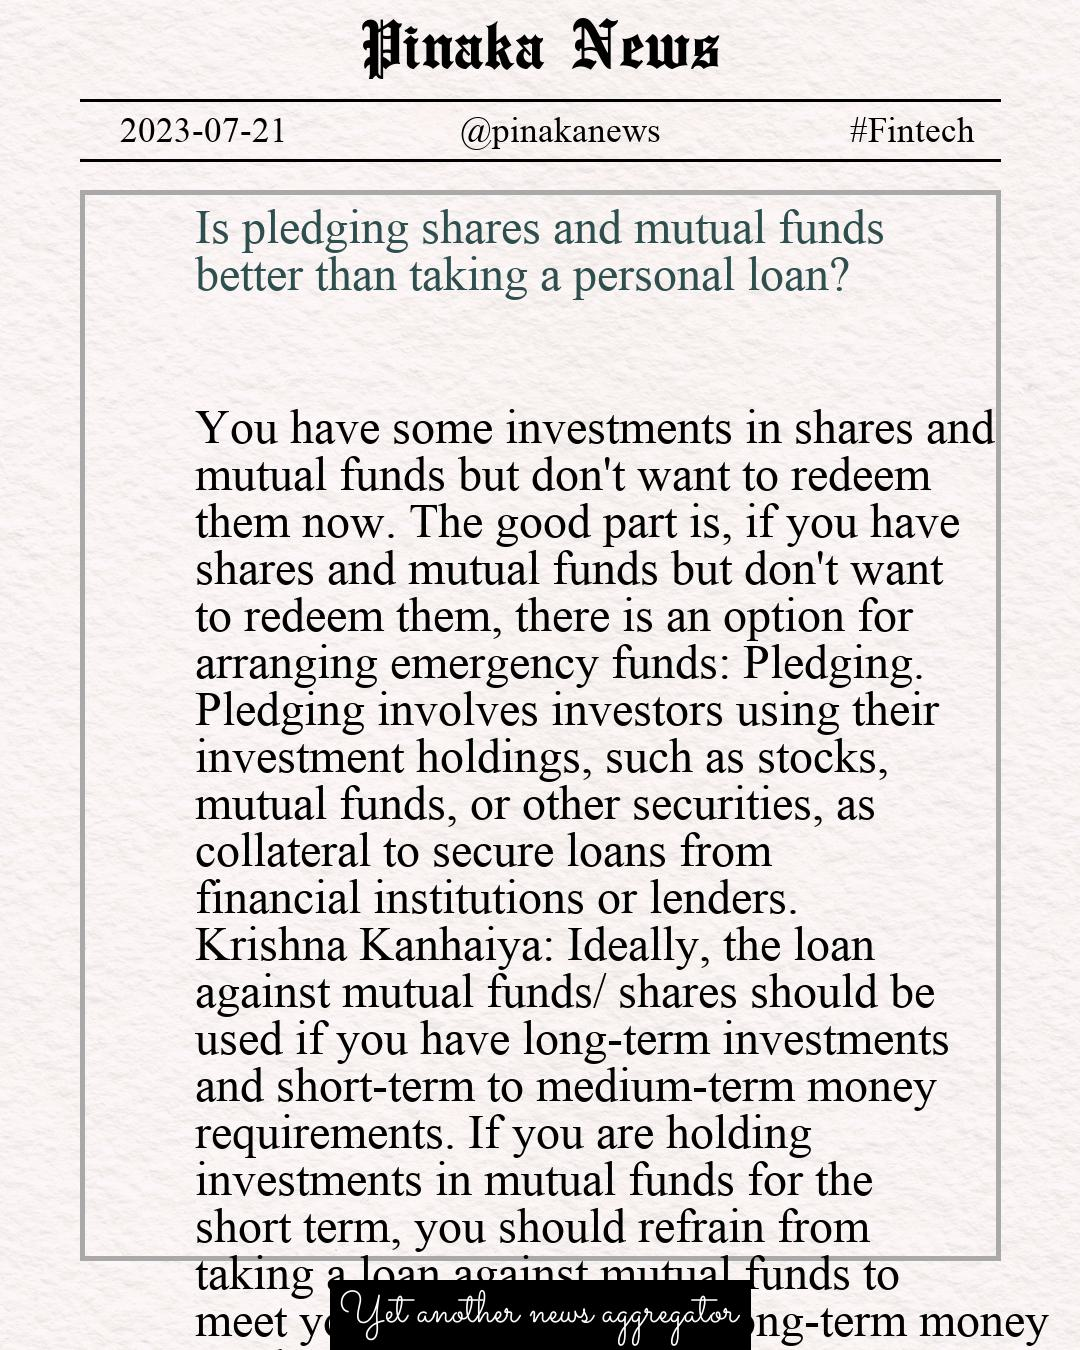

In [23]:
from PIL import Image, ImageFont, ImageDraw 

df = df.reset_index(drop=True)

my_image = Image.open("res/news_bg.jpg").resize((1080, 1350))

for index, row in df.iterrows():
    # Create a copy of the original image and an ImageDraw object
    modified_image = my_image.copy()
    x, y = modified_image.size
    draw = ImageDraw.Draw(modified_image)
    
    # Pinaka
    #draw.rectangle((330, 0, 750, 80), fill='black', width=5)
    pinaka = 'Pinaka News'
    textwidth, textheight = draw.textsize(pinaka, font=ImageFont.truetype('res/EnglishTowne.ttf', 75))
    draw.text((x/2-textwidth/2,0), pinaka, fill='black', font=ImageFont.truetype('res/EnglishTowne.ttf', 75))
    
    # Parallel lines
    draw.line([(80,100), (1000, 100)], fill='black', width=3)
    draw.text((120,110), str(df['publish_date'][index][:10]), fill='black', font=ImageFont.truetype('res/times.ttf', 35))
    draw.text((460,110), '@pinakanews', fill='black', font=ImageFont.truetype('res/times.ttf', 35))
    draw.text((850,110), '#Fintech', fill='black', font=ImageFont.truetype('res/times.ttf', 35))
    draw.line([(80,160), (1000, 160)], fill='black', width=3)
    
    # textbox
    draw.rectangle((80, 190, 1000, 1260), outline='darkgray', width=5)
    
    # title
    title = textwrap.fill(text= str(df['title'][index]), width=40)
    textwidth, textheight = draw.textsize(title, font=ImageFont.truetype('res/times.ttf', 48))
    draw.text((x/2-textwidth/2,200), title, fill='darkslategray', font=ImageFont.truetype('res/times.ttf', 48))
    
    # Summary
    summary = textwrap.fill(text=str(df['summary'][index]), width=40) #.replace(".", ".\n")
    textwidth, textheight = draw.textsize(title, font=ImageFont.truetype('res/times.ttf', 48))
    draw.text((x/2-textwidth/2,400), summary, fill='black', font=ImageFont.truetype('res/times.ttf', 48))
    
    # Footer
    #draw.line([(90,1270), (990,1270)], fill='black', width=3)
    draw.rectangle((330, 1280, 750, 1380), fill='black', width=5)
    
    yana = 'Yet another news aggregator'
    textwidth, textheight = draw.textsize(yana, font=ImageFont.truetype('res/Sacramento-Regular.ttf', 45))
    draw.text((x/2-textwidth/2,1280), yana, fill='white', font=ImageFont.truetype('res/Sacramento-Regular.ttf', 45))
    
    # write images
    modified_image.save("{}/images/{}/result_{}_{}.jpg".format(env, current_date, current_date, index))
    
print('post generation done')




# Display each image
modified_image.show()    
from IPython.display import Image, display
for num in range(5):
    display(Image(filename='{}/images/{}/result_{}_{}.jpg'.format(env, current_date, current_date, num)))

## AI to generate heading and description

In [124]:
# Read today's collected news
directory_path = 'news_data/{}'.format(current_date)
csv_files = [file for file in os.listdir(directory_path) if file.endswith('.csv')]

dataframes = []

for file in csv_files:
    file_path = os.path.join(directory_path, file)
    df = pd.read_csv(file_path)
    dataframes.append(df)

# Concatenate all DataFrames into a single DataFrame
combined_df = pd.concat(dataframes, ignore_index=True)
print(combined_df.shape)

pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 10)  
pd.set_option('display.max_colwidth', 25)
print(combined_df.groupby('source').count())


news = combined_df

# Clean the news - drop dups, filter
news = news.dropna()
#news = news.dropna(subset=['desc'])
print(news.shape)
print(news.groupby('source').count())

news['dt'] = news['publish_date'].str.slice(0, 10)
news.drop(columns='publish_date', inplace=True)
news.rename(columns={'dt': 'publish_date'}, inplace=True)

news = news[["source", "link", "title", "publish_date", "summary", "keywords", "desc"]]
news['publish_date'] = news['publish_date'].fillna(str(current_date))
news['publish_date'] = news['publish_date'].replace('None', str(current_date))

print(news.shape)
print(news.groupby('source').count())
news[["source", "title", "summary", "desc"]]

news['summary'] = news['summary'].str.strip()
news['title'] = news['title'].str.strip()
news = news[news['summary'].str.len() >= 500]

(2600, 7)
                           link  title  publish_date  summary  keywords  desc
source                                                                       
https://www.businessto...    20     20            20       16        20    16
https://www.financiale...    60     60            60       51        60    51
https://www.moneycontr...  2520   2520          2520     1904      2520  1904
(1971, 7)
                           link  title  publish_date  summary  keywords  desc
source                                                                       
https://www.businessto...    16     16            16       16        16    16
https://www.financiale...    51     51            51       51        51    51
https://www.moneycontr...  1904   1904          1904     1904      1904  1904
(1971, 7)
                           link  title  publish_date  summary  keywords  desc
source                                                                       
https://www.businessto...    16   

In [125]:
import spacy
from gensim.models import TfidfModel
from gensim.corpora import Dictionary
from gensim.similarities import MatrixSimilarity

def preprocess(text):
    nlp = spacy.load("en_core_web_sm")
    doc = nlp(text)
    sentences = [sent.text for sent in doc.sents]
    return sentences

def summarize(text, num_sentences=2):
    sentences = preprocess(text)
    dictionary = Dictionary([sentence.split() for sentence in sentences])
    corpus = [dictionary.doc2bow(sentence.split()) for sentence in sentences]
    
    tfidf = TfidfModel(corpus)
    tfidf_corpus = tfidf[corpus]
    
    similarity_matrix = MatrixSimilarity(tfidf_corpus)
    
    query = dictionary.doc2bow(text.split())
    query_tfidf = tfidf[query]
    
    similarities = similarity_matrix[query_tfidf]
    ranked_sentences = sorted(enumerate(similarities), key=lambda item: -item[1])
    
    summary_indices = [idx for idx, _ in ranked_sentences[:num_sentences]]
    summary = [sentences[idx] for idx in sorted(summary_indices)]
    
    return " ".join(summary)



#summary = summarize(df['desc'][1], num_sentences=2)
news = news[news['desc'] != 'https://www.moneycontrol.com/stocksmarketsindia/']
news = news.head(10)
news['spacy_ai'] = news['desc'].apply(lambda x: summarize(x, num_sentences=2))
#print(news[['title', 'GPT2_AI']])
print(news.shape)
news.to_csv('ai.csv')

(10, 8)


In [5]:
#!pip install transformers
#!pip install bert-extractive-summarizer
#!pip install spacy

import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from string import punctuation
from collections import Counter
from heapq import nlargest


nlp = spacy.load('en_core_web_sm')
doc = nlp(df['desc'][0])
df['desc'][0]

len(list(doc.sents))

keyword = []
stopwords = list(STOP_WORDS)
pos_tag = ['PROPN', 'ADJ', 'NOUN', 'VERB']
for token in doc:
    if(token.text in stopwords or token.text in punctuation):
        continue
    if(token.pos_ in pos_tag):
        keyword.append(token.text)
        
freq_word = Counter(keyword)
print(freq_word.most_common(5))
type(freq_word)

max_freq = Counter(keyword).most_common(1)[0][1]
for word in freq_word.keys():  
        freq_word[word] = (freq_word[word]/max_freq)
freq_word.most_common(5)

sent_strength={}
for sent in doc.sents:
    for word in sent:
        if word.text in freq_word.keys():
            if sent in sent_strength.keys():
                sent_strength[sent]+=freq_word[word.text]
            else:
                sent_strength[sent]=freq_word[word.text]
print(sent_strength)

print('')
summarized_sentences = nlargest(3, sent_strength, key=sent_strength.get)
print(summarized_sentences)

print(type(summarized_sentences[0]))

final_sentences = [ w.text for w in summarized_sentences ]
summary = ' '.join(final_sentences)
print(summary)

[('cent', 12), ('stock', 10), ('growth', 8), ('Infosys', 7), ('revenue', 7)]
{Shares of Infosys took a beating on Friday morning, plunging over 9 per cent as a host of brokerages cut their share price targets on the stock following a downward revision FY24 revenue guidance.: 5.416666666666666, The fall was much in line with a steep fall in Infosys American Depositary Receipts (ADRs) overnight.: 2.4166666666666665, The stock fell after the IT giant revised downward its FY24 constant currency (CC) revenue guidance to 1-3.5 per cent compared with 4-7 per cent suggested earlier.: 5.25, This is even as its CC growth for Q1 came in line with Street estimates.: 1.75, Infosys cited lower-than-expected volumes and discretionary spending, delays in decision-making and push-outs in anticipated mega deals.

: 2.166666666666666, "The stock has run up by 19 per cent from its recent lows in April and is currently trading at 22 times one year forward PE, close to its five-year average (22x).: 3.666666

ValueError: cannot index a corpus with zero features (you must specify either `num_features` or a non-empty corpus in the constructor)

In [ ]:
# Function to generate GPT2_text
def gpt2(text):
    generator = pipeline(task='text-generation',  model='gpt2-medium')
    gpt_text = generator(text, max_length=1000, do_sample=True, temperature=0.7, num_return_sequences=1)
    return gpt_text[0]['generated_text']

df['GPT2_AI'] = df['desc'][:1000].apply(gpt2)
df[['GPT2_AI']]